In [188]:
import numpy as np
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
from scipy.optimize import minimize

## Download Data:
 

In [189]:
tickers = ['IBM', 'GOOGL', 'PFE', 'GLD', 'JPM', ]

start = datetime(2015, 1, 1)
end = datetime.today()

adj_close = yf.download(tickers, start= start , end = end, auto_adjust = False)
adj_close = adj_close['Adj Close']
adj_close = adj_close.dropna()

[*********************100%***********************]  5 of 5 completed


## Metrics


In [206]:
daily_returns = np.log(adj_close / adj_close.shift(1))
daily_returns = daily_returns.dropna()

annual_returns = np.exp(daily_returns.mean() * 252)-1

annual_volatility = daily_returns.std(axis=0) * np.sqrt(252)

## Calculate portoflio metrics

In [207]:
rf = 0.04

cov = daily_returns.cov() * 252

def expected_returns(weights, annual_returns):
    return float(weights @ annual_returns)

def std_dev(weights, cov):
    variance = weights @ cov @ weights
    return float(np.sqrt(variance))

def sharpe_ratio(weights, annual_returns, rf, cov):
    return (expected_returns(weights, annual_returns) - rf) / std_dev(weights, cov)


## Minimize Sharp, setting bounds and constraints 

In [208]:
def neg_sharpe(weights,annual_returns , rf, cov):
    return - sharpe_ratio (weights, annual_returns, rf,cov)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0.1, 0.3) for _ in range(len(tickers))]

# setting initial weights assuming they all have equal weights

initial_w = np.array([1/len(tickers)] * len(tickers))
initial_w

array([0.2, 0.2, 0.2, 0.2, 0.2])

## Portofolio Optimization

In [209]:
optimized = minimize(neg_sharpe, initial_w, args=(annual_returns, rf, cov), method="SLSQP", constraints=constraints, bounds=bounds,)

optimal_w = optimized.x
optimal_w

array([0.3, 0.3, 0.1, 0.2, 0.1])

## applying the optimal weight

In [210]:
Portfolio_daily_ret= daily_returns.dot(optimal_w)

optimal_portfolio_return = expected_returns(optimal_w, annual_returns)

optimal_portfolio_volatility = std_dev(optimal_w,cov)

optimal_sharpe_ratio = sharpe_ratio(optimal_w, annual_returns, rf, cov)

Portfolio_cumulative = np.exp(Portfolio_daily_ret.cumsum())
rolling_volatility = Portfolio_daily_ret.rolling(252).std()*np.sqrt(252)


benchmark = yf.download('^GSPC', start = start, end = end, auto_adjust= False)['Adj Close']

benchmark_ret = np.log(benchmark / benchmark.shift(1)).dropna()
benchmark_annual_ret = np.exp(benchmark_ret['^GSPC'].mean() * 252)-1
benchmark_cum = (1 + benchmark_ret).cumprod()
benchmark_vol = benchmark_ret.rolling(252).std()*np.sqrt(252)


cum = pd.concat(
    {"Portfolio": Portfolio_cumulative, "SP500": benchmark_cum}, axis=1).dropna()

vol =  pd.concat(
    {"Portfolio": rolling_volatility,  "SP500": benchmark_vol}, axis =1).dropna()


# portfolio beta :

asset_betas = {}

for ticker in tickers:
    asset_ret = daily_returns[ticker]
    aligned = pd.concat([asset_ret, benchmark_ret], axis=1, keys=[ticker,'^GSPC']).dropna()

    cov = aligned.cov().iloc[0, 1]
    bench_var = aligned['^GSPC'].var()
    asset_betas[ticker] = cov / bench_var

portfolio_beta = np.dot(optimal_w, [asset_betas[t] for t in tickers])


# portfolio alpha :
portfolio_alpha = optimal_portfolio_return - (rf + portfolio_beta * ( benchmark_annual_ret - rf))


[*********************100%***********************]  1 of 1 completed


## plotting the results

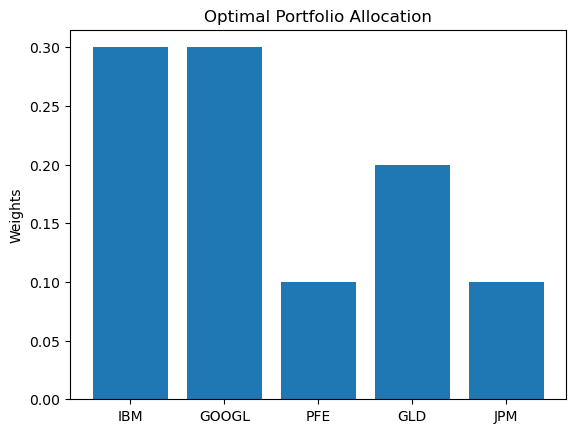

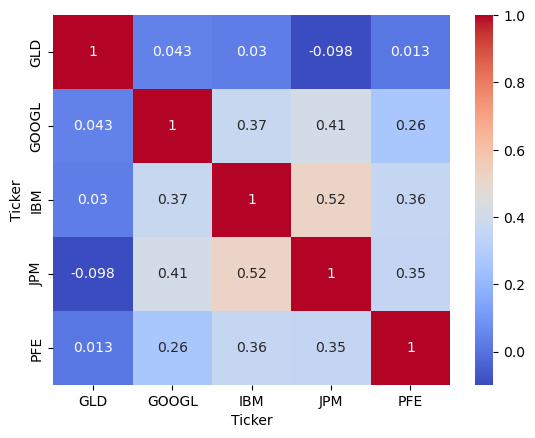

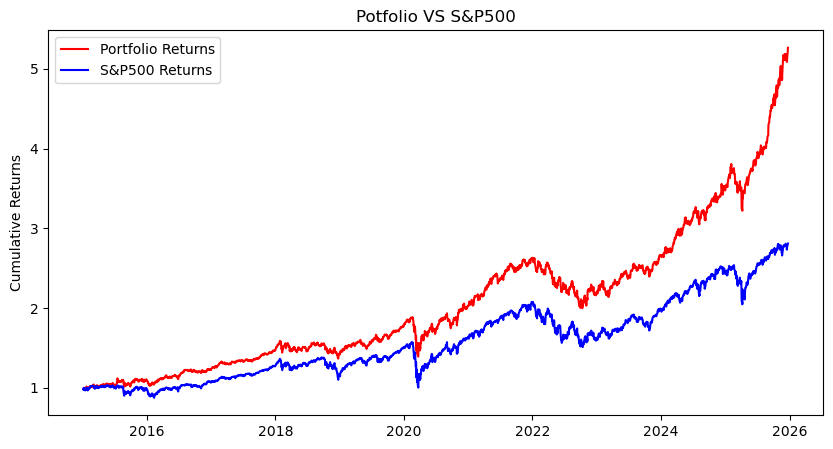

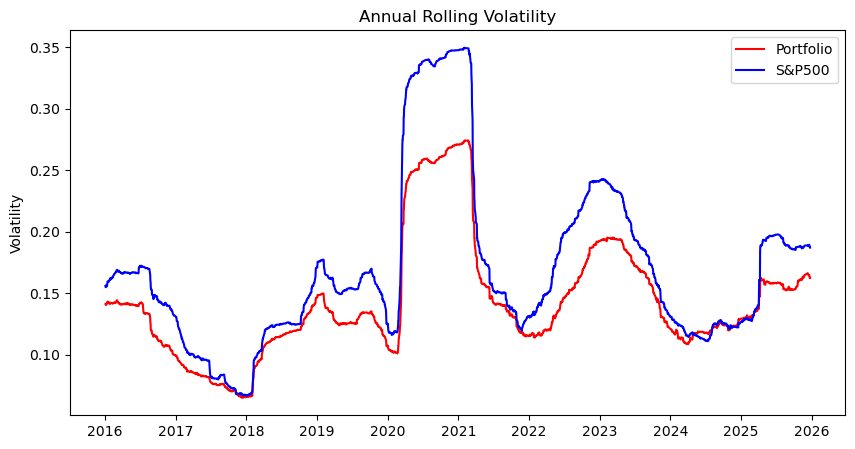

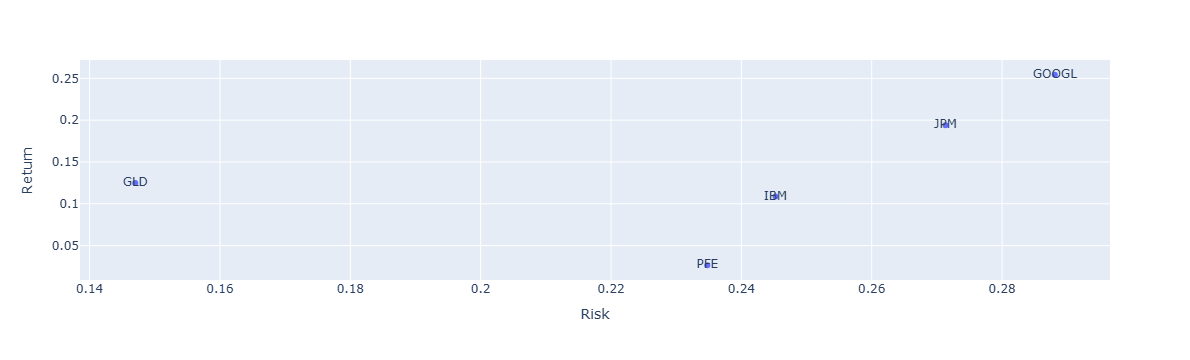

In [211]:
# Plot Asset Allocation
plt.bar(tickers, optimal_w)
plt.ylabel("Weights")
plt.title("Optimal Portfolio Allocation")
plt.show()

corr_matrix = daily_returns.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()


# cummulative return
plt.figure(figsize=(10, 5))
plt.plot(Portfolio_cumulative, color = 'red', label = 'Portfolio Returns')
plt.plot(benchmark_cum, color = 'blue', label = 'S&P500 Returns')
plt.title("Potfolio VS S&P500")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

# Rolling Volatility
plt.figure(figsize=(10, 5))
plt.plot(rolling_volatility, color = 'red', label = 'Portfolio')
plt.plot(benchmark_vol, color = 'blue', label = 'S&P500')
plt.title("Annual Rolling Volatility")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# Create scatter plot
import plotly.express as px
df_summary = pd.DataFrame({
    'Ticker': annual_returns.index,
    'Return': annual_returns.values,
    'Risk': annual_volatility.values
})

fig = px.scatter(df_summary, x='Risk', y='Return', text='Ticker')
fig.show()


## Summary 

In [212]:
def portfolio_summary(tickers, optimal_w, optimal_portfolio_return, optimal_portfolio_volatility, optimal_sharpe_ratio, portfolio_alpha, portfolio_beta):
    """
    Generates a professional-style portfolio summary and recommendation.
    
    Parameters:
    - tickers: list of stock tickers
    - weights: list of optimal weights
    - expected_return: expected annual return (float, e.g., 0.19)
    - volatility: expected annual volatility (float, e.g., 0.19)
    - sharpe: Sharpe ratio (float)
    - alpha: portfolio alpha (float)
    - beta: portfolio beta (float)
    
    Returns:
    - summary: string with portfolio summary and recommendation
    """
    
    # Create a formatted tickers & weights string
    allocation_str = "\n".join([f"  - {t}: {w:.2%}" for t, w in zip(tickers, optimal_w)])
    
    # Build summary
    summary = f"""
Portfolio Summary:
Allocation:
{allocation_str}

Metrics:
- Expected Annual Return: {optimal_portfolio_return:.2%}
- Expected Volatility: {optimal_portfolio_volatility:.2%}
- Sharpe Ratio: {optimal_sharpe_ratio:.2f}
- Alpha: {portfolio_alpha:.2%}
- Beta: {portfolio_beta:.2f}

Recommendation:
- The portfolio shows a {"strong" if optimal_sharpe_ratio >= 0.7 else "moderate"} risk-adjusted performance.
- Diversification is {"well-balanced" if max(optimal_w) <= 0.35 else "slightly concentrated"} across assets.
- Expected returns are {"healthy" if optimal_portfolio_return >= 0.15 else "modest"} relative to risk.
- Consider monitoring beta to assess market sensitivity.
- Rebalance periodically to maintain target weights and risk profile.
"""
    return summary

summary_text = portfolio_summary(
    tickers,
    optimal_w,
    optimal_portfolio_return,
    optimal_portfolio_volatility,
    optimal_sharpe_ratio,
    portfolio_alpha.item(),
    portfolio_beta.item()
)

print(summary_text)



Portfolio Summary:
Allocation:
  - IBM: 30.00%
  - GOOGL: 30.00%
  - PFE: 10.00%
  - GLD: 20.00%
  - JPM: 10.00%

Metrics:
- Expected Annual Return: 16.61%
- Expected Volatility: 15.04%
- Sharpe Ratio: 0.84
- Alpha: 6.70%
- Beta: 0.77

Recommendation:
- The portfolio shows a strong risk-adjusted performance.
- Diversification is well-balanced across assets.
- Expected returns are healthy relative to risk.
- Consider monitoring beta to assess market sensitivity.
- Rebalance periodically to maintain target weights and risk profile.

